In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))

import random
import os.path

import pycamhd.lazycache as lazycache     ## For accessing data through a Lazycache instance
import pycamhd.lazyqt as lazyqt           ## For accessing data on disk or through HTTP

import json

## Local imports
from timer import Timer


from dask import compute,delayed,threaded

In [2]:
## Default values

## These paths must exist in all locations ... the code doesn't check...
ci_url_root = "https://rawdata.oceanobservatories.org/files/"

paths = ['/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T000000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T030000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T060000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T090000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T120000Z.mov'
        ]
local_path = "/data"

local_cached_url   = 'http://localhost:8080/'
local_uncached_url = 'http://localhost:9080/'

local_nginx_url    = 'http://localhost:9081/'

gae_uncached_url   = 'https://camhd-app-dev-nocache.appspot.com/'
gae_cached_url   = 'https://camhd-app-dev.appspot.com/'

DEFAULT_REPS = 100

nthreads = [1,2,4,8]

import platform
hostname = platform.node()
config_file = "%s_config.json" % hostname

results_file = "%s_results.json" % hostname


In [3]:
## import local configuration
if os.path.isfile(config_file):
    print("Loading config file %s" % config_file)
    
    with open( config_file, 'r' ) as f:
        conf = json.load( f )

        
    if 'local_path' in conf.keys(): local_path = conf['local_path']
    if 'default_reps' in conf.keys():       DEFAULT_REPS = conf['default_reps']

Loading config file ursine_config.json


In [4]:
print("Configuration")
print("Local_path: %s" % local_path )
print("Reps: %d" % DEFAULT_REPS )

Configuration
Local_path: /home/aaron/canine/workspace/camhd_analysis/rawdata_mirror/rawdata.oceanobservatories.org/files
Reps: 2


In [33]:
video_lengths = dict()

def draw_frame( rng ):
    movie = rng.sample( paths, 1 )[0]
    
    if movie in video_lengths.keys():
        vid_length = video_lengths[ movie ]
    else:
        ## Check length 
        metadata = lazyqt.get_metadata( ci_url_root + movie )
        vid_length = metadata['num_frames']
        video_lengths[movie] = vid_length
    
    return [movie, rng.randrange( 1, vid_length )]
            
def random_frames( count, seed = -1 ):
    if seed >= 0: 
        #print("Setting random seed to %d" % seed)
        rng = random.Random(seed)
    else:
        rng = random.Random()
        
    return [ draw_frame(rng) for i in range(count) ]

def test_kernel( repo, frame ):
    with Timer() as t:
        ## Todo.   Check quality of outcome
        img = repo.get_frame( frame[0], frame[1] )
        if img is None:
            valid = False
        else:       
            sz = img.shape
            if (sz[0] == 1080) and (sz[1] == 1920):
                valid = True
            else:
                valid = False
            
    out =  {'valid': valid, 'path': frame[0], 'frame': frame[1]}
    if valid:
        out['msecs'] = t.msecs
        
    return out
                
def do_test_repo( repo, count = DEFAULT_REPS, seed = -1, nthreads = 1 ):
    if nthreads == 1:
        results = [test_kernel( repo, frame ) for frame in random_frames( count, seed=seed )]  
    else:
        values = [delayed(test_kernel)( repo, frame ) for frame in random_frames( count, seed=seed )]  
        results = compute(*values, get=threaded.get)
    
    return results
    

def plot_times( results, desc ):
    msec = [t['msecs'] for t in results if t['valid']]
    if len(msec) < 1: return
    
    print("%s: %f ms per frame" % (desc,np.mean(msec)) )

    plt.hist( msec, bins = 20, normed=True )
    plt.xlabel('msec')
    plt.ylabel('frequency')

    
def save_results( results, keys, misc = {} ):
    if os.path.isfile(results_file):
        with open(results_file) as f:
            try:
                jresults = json.load( f )
            except json.JSONDecodeError:
                jresults = dict()
            
    else:
        jresults = dict()
    
    newdata = dict()
    newdata['results'] = results
    newdata.update(misc)  
    
    ## Nested keys
    d = jresults
    for k in keys[:-1]:
        d = d.setdefault(k, {})
        
    d[keys[-1]] = newdata

    
    with open(results_file,'w') as f:
        json.dump( jresults, f, indent=2 )
   
    

def run_analysis( repo, keys, seed = -1 ):
    for nt in nthreads:
        if seed >= 0:
            seed = seed+nt

        results = do_test_repo( repo, nthreads=nt, seed=seed )

        newkey = keys + ["%d_threads" % nt]
        plot_times( results, newkey )
        
        misc={'nthreads': nt}
        if seed >= 0: misc['seed'] = seed
        
        save_results(results, newkey, misc ) 

# Direct LazyQT conversion

### Direct disk access

1997
23736
['lazyqt', 'local_disk', '1_threads']: 140.358806 ms per frame
241722282

['lazyqt', 'local_disk', '2_threads']: 797.010660 ms per frame
197321763
['lazyqt', 'local_disk', '4_threads']: 107.574940 ms per frame

220738140

['lazyqt', 'local_disk', '8_threads']: 149.219871 ms per frame


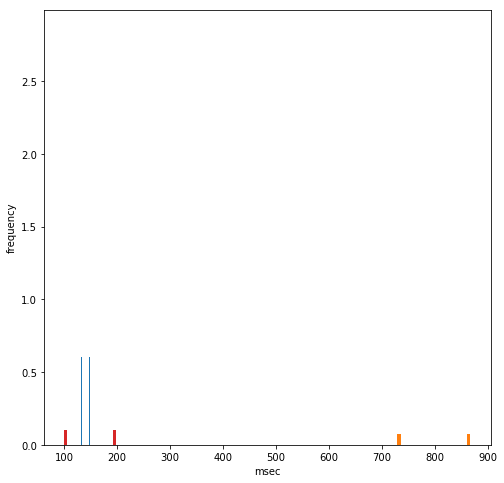

In [26]:
run_analysis( lazyqt.LazyQtAccessor( local_path ), ["lazyqt","local_disk"])

### Local HTTP server serving local data

['lazyqt', 'local_nginx', '1_threads']: 168.036222 ms per frame
['lazyqt', 'local_nginx', '2_threads']: 379.834890 ms per frame
['lazyqt', 'local_nginx', '4_threads']: 572.643757 ms per frame
['lazyqt', 'local_nginx', '8_threads']: 186.953187 ms per frame


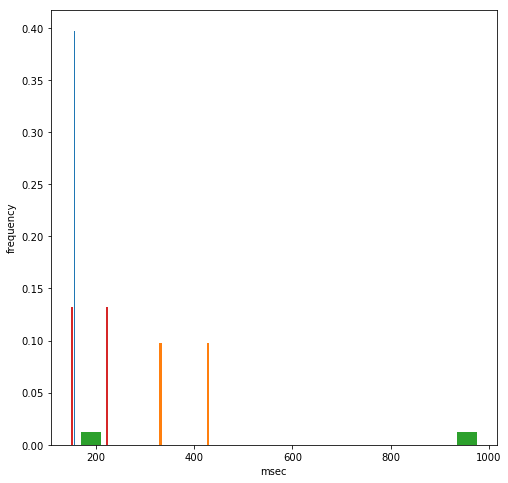

In [7]:
run_analysis( lazyqt.LazyQtAccessor( local_nginx_url ), ["lazyqt","local_nginx"] )

### Contacting CI directly 

['lazyqt', 'ci', '1_threads']: 3436.890841 ms per frame
['lazyqt', 'ci', '2_threads']: 5128.991842 ms per frame
['lazyqt', 'ci', '4_threads']: 5085.788012 ms per frame
['lazyqt', 'ci', '8_threads']: 5143.245220 ms per frame


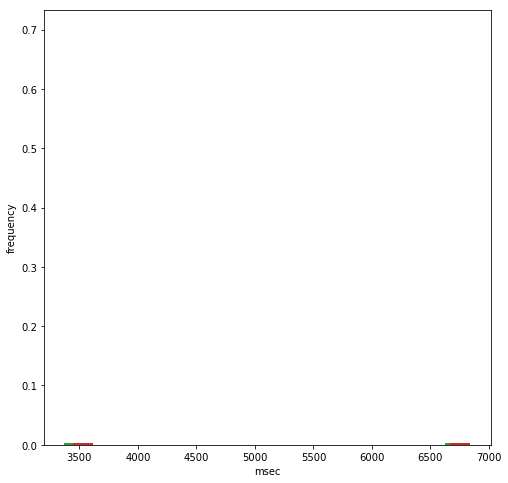

In [8]:
run_analysis( lazyqt.LazyQtAccessor( ci_url_root ), ["lazyqt","ci"] )

# Local lazycache server, non-caching


### Using local disk

In [9]:
def lazycache_berna( host ):
    return lazycache.LazycacheAccessor("%s/v1/berna/data/" % host)

def lazycache_nginx( host ):
    return lazycache.LazycacheAccessor("%s/v1/nginx_data/" % host)

def lazycache_ci( host ):
        return lazycache.LazycacheAccessor("%s/v1/org/oceanobservatories/rawdata/files/" % host)
    
keys = ["lazycache","local","uncached"]

['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 1255.761147 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 1312.101007 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '4_threads']: 257.022858 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '8_threads']: 1309.435248 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 1442.100525 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 1345.875025 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '4_threads']: 283.860207 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '8_threads']: 1160.774112 ms per frame


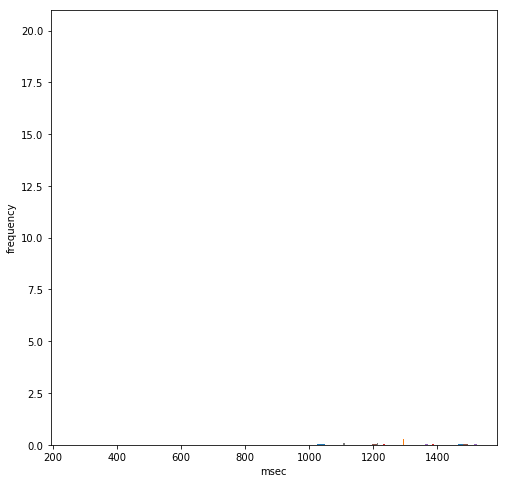

In [34]:

## run this one twice to demonstrate caching isn't enabled

seed = random.randint(0,65535)

run_analysis( lazycache_berna( local_uncached_url ), keys + ["local_disk"], seed = seed  )
run_analysis( lazycache_berna( local_uncached_url ), keys + ["local_disk"], seed = seed  )

### connecting to local HTTP server

['lazycache', 'local', 'cached', 'local_nginx', '1_threads']: 1450.509548 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '2_threads']: 1210.989952 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '8_threads']: 1289.855480 ms per frame


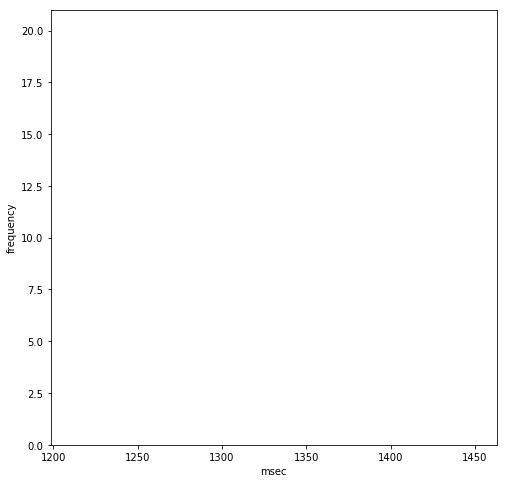

In [16]:
run_analysis( lazycache_nginx( local_uncached_url ), keys + ["local_nginx"]  )

### contacting CI directly

['lazycache', 'local', 'cached', 'ci', '1_threads']: 2126.884818 ms per frame
['lazycache', 'local', 'cached', 'ci', '2_threads']: 2226.188064 ms per frame
['lazycache', 'local', 'cached', 'ci', '4_threads']: 2062.732100 ms per frame
['lazycache', 'local', 'cached', 'ci', '8_threads']: 2103.678346 ms per frame


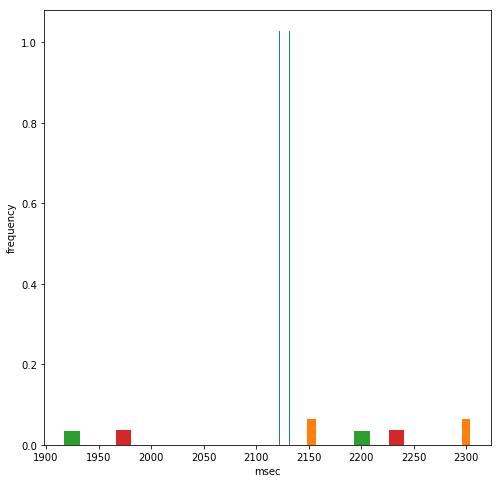

In [17]:
run_analysis( lazycache_ci( local_uncached_url ), keys + ["ci"]  )

# Local Lazycache server, with caching enabled


['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 1482.074261 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 2076.911569 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '4_threads']: 1260.611176 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '8_threads']: 1872.932434 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 1115.862131 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 979.294777 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '4_threads']: 1053.139329 ms per frame
['lazycache', 'local', 'cached', 'local_disk', '8_threads']: 1182.187438 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '1_threads']: 1158.222556 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '2_threads']: 1430.216193 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '4_threads']: 768.770218 ms per frame
['lazycache', 'local', 'cached', 'local_nginx', '8_th

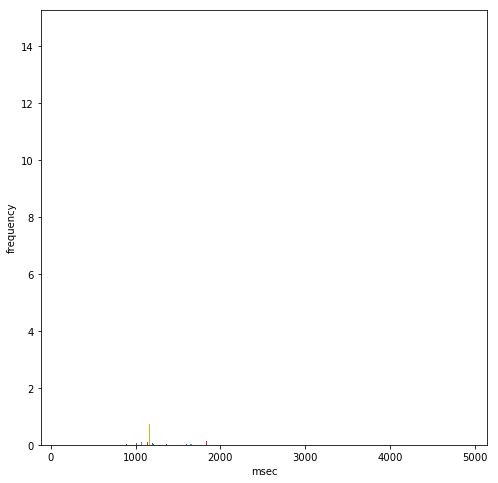

In [35]:
keys = ["lazycache","local","cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed )
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed )

seed = random.randint(0,65535)
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed  )
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed  )

seed = random.randint(0,65535)
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed  )
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed  )

# Google App Engine instance of Lazycache

## Without cache

['lazycache', 'gae', 'uncached', 'ci', '1_threads']: 4575.182080 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '2_threads']: 3985.143900 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '4_threads']: 4260.840416 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '8_threads']: 3732.289076 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '1_threads']: 3491.905451 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '2_threads']: 3869.384408 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '4_threads']: 4183.405399 ms per frame
['lazycache', 'gae', 'uncached', 'ci', '8_threads']: 3866.662860 ms per frame


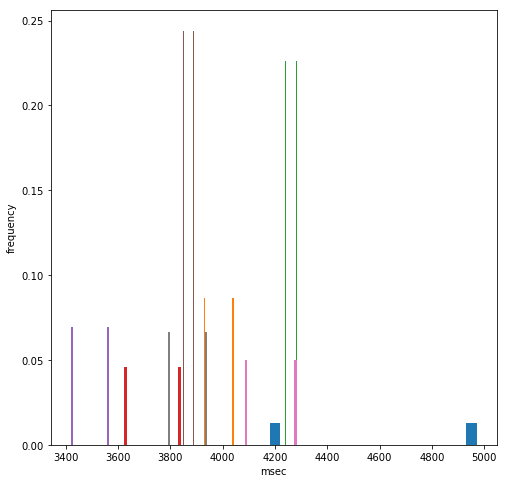

In [36]:
keys = ["lazycache", "gae", "uncached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed )
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed  )

### With cache

['lazycache', 'gae', 'cached', 'ci', '1_threads']: 4797.819138 ms per frame
['lazycache', 'gae', 'cached', 'ci', '2_threads']: 4932.336211 ms per frame
['lazycache', 'gae', 'cached', 'ci', '4_threads']: 4983.577967 ms per frame
['lazycache', 'gae', 'cached', 'ci', '8_threads']: 5441.989541 ms per frame
['lazycache', 'gae', 'cached', 'ci', '1_threads']: 2498.637795 ms per frame
['lazycache', 'gae', 'cached', 'ci', '2_threads']: 2416.334152 ms per frame
['lazycache', 'gae', 'cached', 'ci', '4_threads']: 2371.789336 ms per frame
['lazycache', 'gae', 'cached', 'ci', '8_threads']: 2217.512131 ms per frame


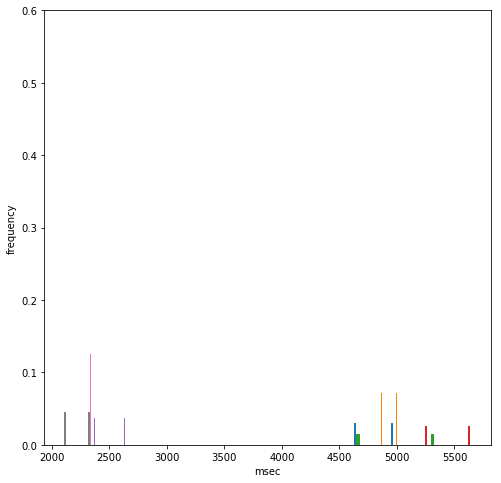

In [37]:
keys = ["lazycache", "gae", "cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed  )
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed  )